<a href="https://colab.research.google.com/github/SelinaZ07/NASA-Space-App-challenge/blob/main/Nasa_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nasa k-means
This file uses k-means clustering to categorize the 600ish research papers from Nasa into 10 categories. Then I also plotted a scatterplot and a tree map.

In [ ]:
!pip install sentence-transformers scikit-learn pandas numpy umap-learn matplotlib joblib openai

In [ ]:

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install sentence-transformers

Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
!pip install -U transformers==4.44.2
!pip install -U sentence-transformers==2.7.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.1
    Uninstalling sentence-transformers-5.1.1:
      Successfully uninstalled sentence-transformers-5.1.1


In [ ]:
from google.colab import files
uploaded = files.upload()   # choose your CSV file

Saving SB_publication_PMC.csv to SB_publication_PMC.csv


In [ ]:
#embeddings
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

df = pd.read_csv("/content/SB_publication_PMC.csv")               # must have 'title' col
df = df.drop_duplicates(subset=["Title"]).reset_index(drop=True)
titles = df['Title'].astype(str).tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')   # or 'all-mpnet-base-v2'
embeddings = model.encode(titles, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
# embeddings: shape (n_titles, dim)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA

# reduce to 50 dimensions (good balance for clustering)
pca = PCA(n_components=50, random_state=42)
X = pca.fit_transform(embeddings)


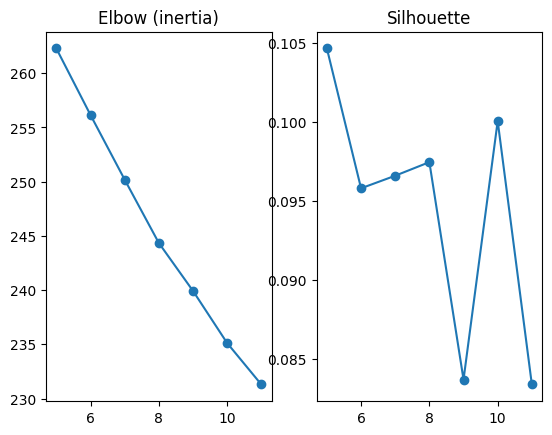

In [ ]:
#Elbow method to find k value
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ks = list(range(5,12))
inertias, sil_scores = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, km.labels_))

plt.subplot(1,2,1); plt.plot(ks, inertias, '-o'); plt.title("Elbow (inertia)")
plt.subplot(1,2,2); plt.plot(ks, sil_scores, '-o'); plt.title("Silhouette")
plt.show()

In [ ]:
k = 10  # chosen after diagnostics
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
labels = kmeans.fit_predict(X)
df['cluster'] = labels

#Plot the k-means clustering graphs
import numpy as np
from sklearn.metrics import silhouette_samples

# sizes
sizes = df.groupby('cluster').size().sort_values(ascending=False)
print(sizes)

# silhouette per sample
s_samples = silhouette_samples(X, labels)
df['silhouette'] = s_samples

# representative titles per cluster
reps = {}
for c in range(k):
    idx = np.where(labels == c)[0]
    centroid = kmeans.cluster_centers_[c]
    # distance in PCA space:
    dists = np.linalg.norm(X[idx] - centroid, axis=1)
    reps[c] = df.iloc[idx[np.argmin(dists)]]['Title']
    print(f"Cluster {c} ({len(idx)}): rep title: {reps[c]}")

cluster
2    100
5     97
6     84
1     82
0     62
8     53
4     46
3     35
9     25
7     18
dtype: int64
Cluster 0 (62): rep title: Bone shaft bending strength index is unaffected by exercise and unloading in mice
Cluster 1 (82): rep title: Microbial existence in controlled habitats and their resistance to space conditions
Cluster 2 (100): rep title: Uncovering transcriptional responses to fractional gravity in Arabidopsis roots
Cluster 3 (35): rep title: Interplay of space radiation and microgravity in DNA damage and DNA damage response.
Cluster 4 (46): rep title: Draft Genome Sequences of Fungi Isolated from the International Space Station during the Microbial Tracking-2 Experiment
Cluster 5 (97): rep title: Transcriptomics, NF-Œ∫B Pathway, and Their Potential Spaceflight-Related Health Consequences.
Cluster 6 (84): rep title: Environmental cues and symbiont microbe-associated molecular patterns function in concert to drive the daily remodelling of the crypt-cell brush border o

In [ ]:
#Identify keyword for each clustering
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
tfidf = vectorizer.fit_transform(df['Title'])
feature_names = vectorizer.get_feature_names_out()

def top_keywords_for_cluster(cluster_label, n=8):
    idx = np.where(labels == cluster_label)[0]
    mean_tfidf = tfidf[idx].mean(axis=0).A1   # average tfidf per term
    topn = mean_tfidf.argsort()[::-1][:n]
    return [feature_names[i] for i in topn]

for c in range(k):
    print(c, top_keywords_for_cluster(c, n=8))

0 ['bone', 'mice', 'unloading', 'skeletal', 'muscle', 'bone marrow', 'marrow', 'leptin']
1 ['space', 'microbiome', 'microbial', 'station', 'space station', 'international space', 'international', 'spaceflight']
2 ['arabidopsis', 'plant', 'thaliana', 'arabidopsis thaliana', 'plants', 'root', 'signaling', 'spaceflight']
3 ['radiation', 'space radiation', 'dose', 'simulated', 'low dose', 'ionizing', 'ionizing radiation', 'damage']
4 ['space station', 'international space', 'station', 'international', 'isolated', 'genome', 'isolated international', 'draft genome']
5 ['spaceflight', 'mouse', 'effects', 'space', 'effects spaceflight', 'mice', 'expression', 'brain']
6 ['protein', 'drosophila', 'proteins', 'stress', 'desiccation', 'expression', 'mscl', 'cell']
7 ['elegans', 'caenorhabditis elegans', 'caenorhabditis', 'strength', 'microfluidics', 'decline', 'decline caenorhabditis', 'microfluidic']
8 ['microgravity', 'stem', 'simulated', 'simulated microgravity', 'bone', 'spaceflight', 'changes

In [ ]:
#saving the files
df['cluster'] = labels   # numeric cluster id from KMeans
cluster_labels = {
    0: "Skeletal & Musculoskeletal Biology",
    1: "Spaceflight Microbiome Dynamics",
    2: "Plant Growth & Signaling",
    3: "Space Radiation Biology",
    4: "Space Station Genomics",
    5: "Neurobiology in Spaceflight",
    6: "Cellular Stress Responses",
    7:"C. elegans Model Systems",
    8:"Microgravity & Stem Cells",
    9:"Space Omics & Exploration"
}
df['category'] = df['cluster'].map(cluster_labels)
df.to_csv("titles_with_categories.csv", index=False)
from google.colab import files
files.download("titles_with_categories.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from umap import UMAP

umap_2d = UMAP(n_components=2, random_state=42)
X_2d = umap_2d.fit_transform(X)

df['x'] = X_2d[:,0]
df['y'] = X_2d[:,1]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
import plotly.express as px

# Count how many papers per category
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Create treemap
fig = px.treemap(
    category_counts,
    path=['category'],  # hierarchy: only categories here, but you could add subcategories
    values='count',
    color='count',  # color intensity based on paper count
    color_continuous_scale='Blues',  # you can try 'Viridis', 'Plasma', 'Tealgrn', etc.
    title="Distribution of Research Papers by Category"
)

# Increase font size and layout style
fig.update_traces(textfont_size=20)   # make labels larger
fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
fig.show()

#Download it as a html file
fig.write_html("treemap.html")




In [ ]:
import plotly.express as px

fig = px.scatter(
    df,
    x="x", y="y",
    color="category",  # your named clusters
    hover_data=["Title", "category"],
    title="Space Biology Research Clusters"
)

fig.show()


In [ ]:
#output to html files so it can be displayed on website
fig.write_html("clusters.html")
from google.colab import files
files.download("clusters.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>